In [131]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score, recall_score, precision_score, f1_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import ElasticNet
from sklearn.svm import LinearSVR
from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import Ridge

%matplotlib inline

In [132]:
df = pd.read_csv('FormattedData/FN_formatted.csv', index_col = 0)
df.dropna(inplace = True)

In [ ]:
def remove_corrs(df):
    
    corrs = df.corr().stack().reset_index()
    corrs.columns = ['1','2','R2']
    temp = corrs[(corrs.R2 > .8) & (corrs.R2 < .999)].sort_values('R2', ascending = False).reset_index(drop = True)
    correlations = temp[temp.index % 2 == 0]
    
    corr_index = correlations['1'].value_counts().index
    to_drop = round(len(corr_index)*.9)
    
    df2 = df.drop(corr_index[:to_drop], axis = 1)
    
    return df2

In [1]:
def preprocess_data(df):
    
    df.index = pd.to_datetime(df.index)
    
    X = df.shift(1).dropna()
    y = df['adjustedclose'].iloc[1:]
    
    train_num = round(len(X)*.8)
    test_num = round(len(X)*.2)
    print(train_num, test_num)
    
    X_train = X.iloc[:train_num]
    X_test = X.iloc[-test_num:]
    y_train = y.iloc[:train_num]
    y_test = y.iloc[-test_num:]
    
    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns).set_index(X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns).set_index(X_test.index)
    
    return X_train, X_test, y_train, y_test

In [139]:
def EN_test(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'l1_ratio': [.01,.25,.5,.75,1],
    'alpha': [.01,.25,.5,.75,1],
    }
    
    # Instantiate & fit RidgeRegression
    en = ElasticNet(random_state = 42, max_iter = 10e5)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=en, param_grid=grid, cv=cv, scoring='r2', n_jobs = -1)
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    ridge_params = gs.best_params_
    
    print(ridge_params)
    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    print(f'Train Mean Accuracy Score: {train_score}')
    test_score = gs.score(X_test, y_test)
    print(f'Test Mean Accuracy Score: {test_score}')
    
    preds_train = pd.concat([y_train, pd.DataFrame(y_hat_train, columns = ['predictions'], index = y_train.index), df.day_direction], axis = 1)
    preds_train.dropna(inplace = True)

    preds_train['direction'] = np.where(preds_train.predictions > preds_train.adjustedclose.shift(1), 1, 0)
    preds_train['correct'] = np.where(preds_train['direction'] == preds_train['day_direction'], 1, 0)
    train_correct = preds_train['correct'].value_counts(normalize = True)
    
    preds_test = pd.concat([y_test, pd.DataFrame(y_hat_test, columns = ['predictions'], index = y_test.index), df.day_direction], axis = 1)
    preds_test.dropna(inplace = True)

    preds_test['direction'] = np.where(preds_test.predictions > preds_test.adjustedclose.shift(1), 1, 0)
    preds_test['correct'] = np.where(preds_test['direction'] == preds_test['day_direction'], 1, 0)
    test_correct = preds_test['correct'].value_counts(normalize = True)

    print(f'The train prediction is correct: {train_correct[1]}')
    print(f'The test prediction is correct: {test_correct[1]}')
    return y_pred

In [140]:
y_preds = EN_test(X_train_scaled,X_test_scaled,y_train,y_test)

{'alpha': 0.01, 'l1_ratio': 1}
Mean Cross-Val Score: 0.9650417456482254
Train Mean Accuracy Score: 0.9961588308145274
Test Mean Accuracy Score: 0.9885513619459025
The train prediction is correct: 0.5116796440489433
The test prediction is correct: 0.49333333333333335


In [141]:
def SVR_test(X_train, X_test, y_train, y_test, cv=5):
    
    svr = LinearSVR(random_state = 42, max_iter = 10e5)
    svrmodel = svr.fit(X_train_scaled, y_train)
    
    train_score = svr.score(X_train_scaled, y_train)
    y_hat_train = svr.predict(X_train_scaled)
    train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
    train_cv_score = cross_val_score(svrmodel, X_train_scaled, y_train, n_jobs = -1).mean()

    
    test_score = svr.score(X_test_scaled, y_test)
    y_hat_test = svr.predict(X_test_scaled)
    test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

    print(f'Train Score : {train_score}')
    print(f'Mean Train Cross-Validation Score: {train_cv_score}')
    print(f'Test Score : {test_score}')
    print(f'Train RMSE : {train_rmse}')
    print(f'Test RMSE : {test_rmse}')
    
    preds_train = pd.concat([y_train, pd.DataFrame(y_hat_train, columns = ['predictions'], index = y_train.index), df.day_direction], axis = 1)
    preds_train.dropna(inplace = True)

    preds_train['direction'] = np.where(preds_train.predictions > preds_train.adjustedclose.shift(1), 1, 0)
    preds_train['correct'] = np.where(preds_train['direction'] == preds_train['day_direction'], 1, 0)
    train_correct = preds_train['correct'].value_counts(normalize = True)
    
    preds_test = pd.concat([y_test, pd.DataFrame(y_hat_test, columns = ['predictions'], index = y_test.index), df.day_direction], axis = 1)
    preds_test.dropna(inplace = True)

    preds_test['direction'] = np.where(preds_test.predictions > preds_test.adjustedclose.shift(1), 1, 0)
    preds_test['correct'] = np.where(preds_test['direction'] == preds_test['day_direction'], 1, 0)
    test_correct = preds_test['correct'].value_counts(normalize = True)

    print(train_correct[1])
    print(test_correct[1])
    return y_hat_train, y_hat_test

In [142]:
y_hat_train, y_hat_test = SVR_test(X_train_scaled, X_test_scaled, y_train, y_test)

Train Score : 0.9960962807919526
Mean Train Cross-Validation Score: 0.9648453339640224
Test Score : 0.9885148397984951
Train RMSE : 0.9192215564316866
Test RMSE : 1.916168985249017
0.5116796440489433
0.49333333333333335


In [143]:
def Ridge_test(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
    'alpha': [.01, .05, .1,.5,.75,1],
    }
    
    # Instantiate & fit RidgeRegression
    ridge = Ridge(random_state = 42, max_iter = 10e5)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=ridge, param_grid=grid, cv=cv, scoring='r2', n_jobs = -1)
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    ridge_params = gs.best_params_
    
    # Create prediction variable using test data
    y_hat_train = gs.predict(X_train)
    y_hat_test = gs.predict(X_test)

    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv)
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)

    train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
    test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)
    
    print(f'Train Score: {train_score}')
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    print(f'Test Score: {test_score}')
    print(f'Train RMSE: {train_rmse}')
    print(f'Test RMSE: {test_rmse}')
    
    preds_train = pd.concat([y_train, pd.DataFrame(y_hat_train, columns = ['predictions'], index = y_train.index), df.day_direction], axis = 1)
    preds_train.dropna(inplace = True)

    preds_train['direction'] = np.where(preds_train.predictions > preds_train.adjustedclose.shift(1), 1, 0)
    preds_train['correct'] = np.where(preds_train['direction'] == preds_train['day_direction'], 1, 0)
    train_correct = preds_train['correct'].value_counts(normalize = True)
    
    preds_test = pd.concat([y_test, pd.DataFrame(y_hat_test, columns = ['predictions'], index = y_test.index), df.day_direction], axis = 1)
    preds_test.dropna(inplace = True)

    preds_test['direction'] = np.where(preds_test.predictions > preds_test.adjustedclose.shift(1), 1, 0)
    preds_test['correct'] = np.where(preds_test['direction'] == preds_test['day_direction'], 1, 0)
    test_correct = preds_test['correct'].value_counts(normalize = True)

    print(train_correct[1])
    print(test_correct[1])

In [144]:
Ridge_test(X_train_scaled, X_test_scaled, y_train, y_test)

Train Score: 0.9961852878464671
Mean Cross-Val Score: 0.9648421982138705
Test Score: 0.9872008463307993
Train RMSE: 0.9086817401144781
Test RMSE: 2.022813784419853
0.514460511679644
0.4688888888888889


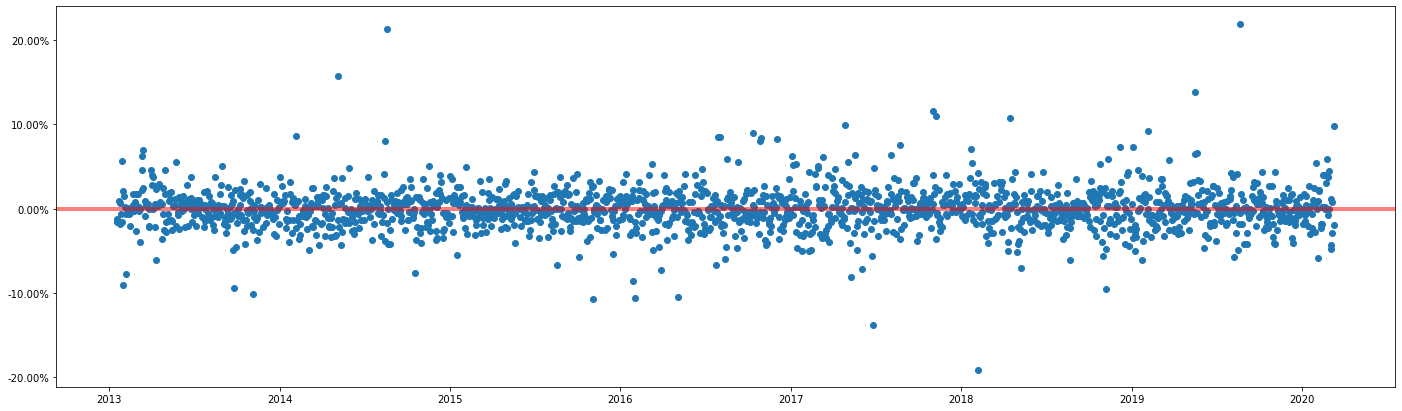

In [145]:
fig, ax = plt.subplots(figsize = (24,7))
plot_x = y_train.index
plot_y = (y_hat_train - y_train)/y_train
plt.scatter(plot_x,plot_y)
ax.yaxis.set_major_formatter('{x:1,.2%}')
plt.axhline(y=0, alpha = .5, color = 'red', linewidth = 4.0);

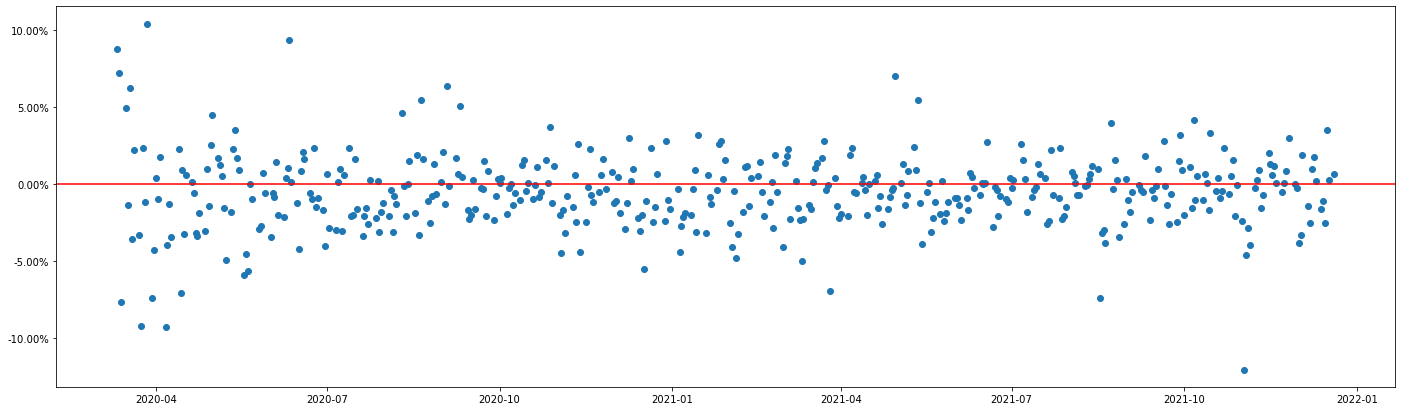

In [146]:
fig2, ax = plt.subplots(figsize = (24,7))
ax.scatter(y_test.index, (y_hat_test - y_test)/y_test)
ax.yaxis.set_major_formatter('{x:1,.2%}')
plt.axhline(y=0, alpha = 1, color = 'red');

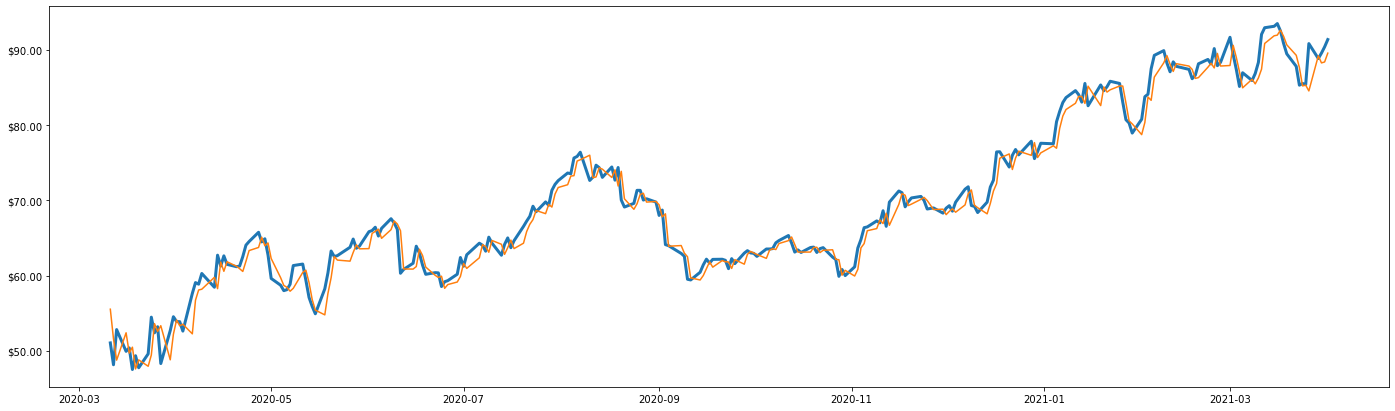

In [151]:
fig3, ax = plt.subplots(figsize = (24,7))
fig3_data = preds_test[(preds_test.index >= '1-1-2020') & (preds_test.index <= '4-1-2021')]
ax.plot(fig3_data.adjustedclose, linewidth = 3.0)
ax.plot(fig3_data.predictions)
ax.yaxis.set_major_formatter('${x:1,.2f}');

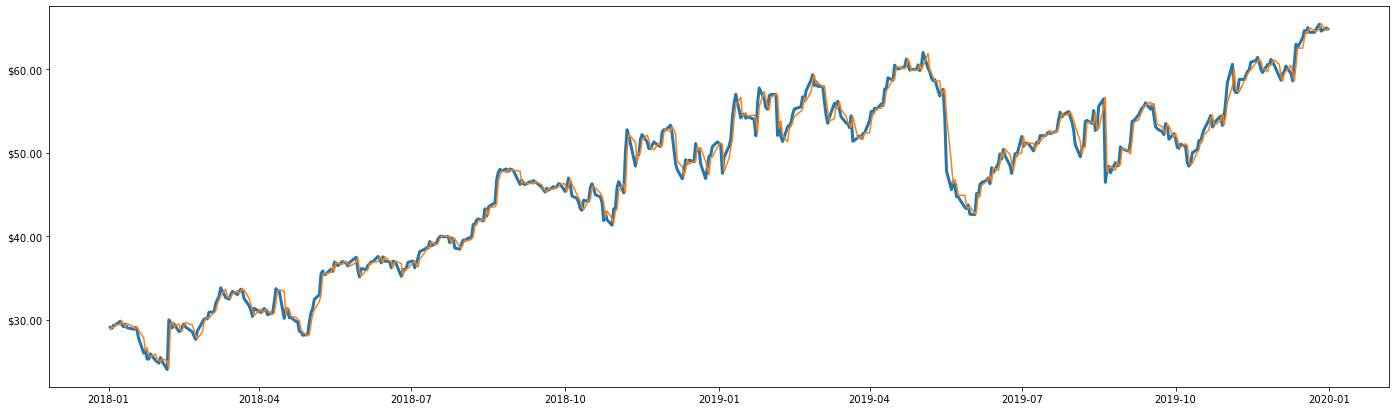

In [152]:
fig4, ax = plt.subplots(figsize = (24,7))
fig4_data = preds_train[(preds_train.index >= '1-1-2018') & (preds_train.index <= '1-1-2020')]
ax.plot(fig4_data.adjustedclose, linewidth = 3.0)
ax.plot(fig4_data.predictions)
ax.yaxis.set_major_formatter('${x:1,.2f}');

In [ ]:
#show prediction distance from previous close.